In [1]:
import pandas as pd
import numpy as np
# load libraries  45.03423447058859 42.58356449833813

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import StratifiedGroupKFold,StratifiedShuffleSplit,KFold,train_test_split
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import lightgbm as lgb
from sklearn.model_selection import KFold
import numpy as np
import lightgbm as lgb
from catboost import CatBoostRegressor
from scipy.optimize import minimize
from tqdm import tqdm
from xgboost import XGBRegressor
import copy
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
import optuna

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [2]:
#data
train=pd.read_csv("dataset/train_features.csv")
y=pd.read_csv("dataset/train_labels.csv")
test=pd.read_csv("dataset/test_features.csv")
ss=pd.read_csv("dataset/submission_format.csv")
test_ground_truth=pd.read_csv("dataset/sdoh_test_labels.csv")

In [3]:
train.head(2)

,uid,age_03,urban_03,married_03,n_mar_03,edu_gru_03,n_living_child_03,migration_03,glob_hlth_03,adl_dress_03,...,rrelgimp_12,rrfcntx_m_12,rsocact_m_12,rrelgwk_12,a16a_12,a21_12,a22_12,a33b_12,a34_12,j11_12
0,aace,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.somewhat important,9.Never,9.Never,0.No,NaN,NaN,NaN,NaN,NaN,Concrete 2
1,aanz,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.very important,9.Never,1.Almost every day,0.No,NaN,NaN,NaN,NaN,NaN,Concrete 2


In [4]:
test.head(2)

,uid,age_03,urban_03,married_03,n_mar_03,edu_gru_03,n_living_child_03,migration_03,glob_hlth_03,adl_dress_03,...,rrelgimp_12,rrfcntx_m_12,rsocact_m_12,rrelgwk_12,a16a_12,a21_12,a22_12,a33b_12,a34_12,j11_12
0,abxu,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Wood, mosaic, or other covering 1"
1,aeol,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.very important,9.Never,9.Never,1.Yes,NaN,NaN,NaN,NaN,NaN,Concrete 2


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Columns: 184 entries, uid to j11_12
dtypes: float64(140), object(44)
memory usage: 4.6+ MB


In [6]:
#let merge train and label
merged_df = pd.merge(train, y, on='uid', how='left')

In [7]:
merged_df["year"]

0       2021
1       2021
2       2016
3       2021
4       2021
        ... 
4338    2021
4339    2016
4340    2021
4341    2021
4342    2021
Name: year, Length: 4343, dtype: int64

In [8]:
#so many missing values
merged_df.isnull().sum()

uid                   0
age_03             1456
urban_03           1454
married_03         1454
n_mar_03           1482
                   ... 
a33b_12            4288
a34_12             1601
j11_12               89
year                  0
composite_score       0
Length: 186, dtype: int64

In [9]:
#lets merged test AND sample submission
merged_test = pd.merge(test, ss, on='uid', how='left')

In [10]:
merged_test["year"]

0       2016
1       2016
2       2021
3       2016
4       2021
        ... 
1100    2016
1101    2021
1102    2016
1103    2021
1104    2021
Name: year, Length: 1105, dtype: int64

<Axes: title={'center': 'Target Distribution'}, ylabel='Frequency'>

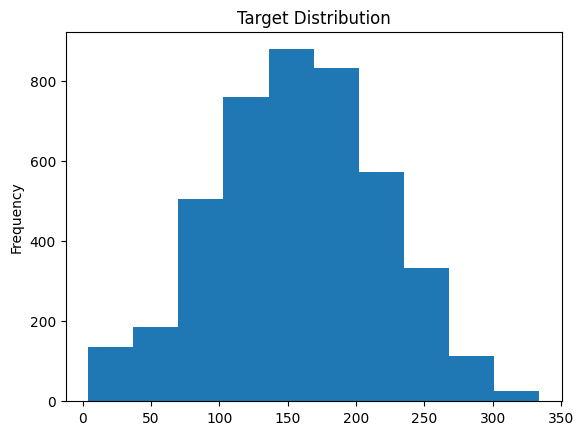

In [11]:
merged_df['composite_score'].plot(kind='hist',title='Target Distribution')

In [12]:
# create new features by combining 2003 and 2012 scores and numbering ordinal variables
def feature_engineering(data):
    data['rjob_hrswk_change'] = (data['rjob_hrswk_12'] - data['rjob_hrswk_03']).astype(float)
    data['max_work_year']=data[['rjob_end_12','rjob_end_03']].max(axis=1).astype(float)
    data['years_since_work']=(data['year']-data['max_work_year']).astype(float)
    data['hincome_change']=(data['hincome_12']-data['hincome_03']).astype(float)
    data['niadl_change']=(data['n_iadl_12']-data['n_iadl_03']).astype(float)
    data['adl_change']=(data['n_adl_12']-data['n_adl_03']).astype(float)
    data['depr_change']=(data['n_depr_12']-data['n_depr_03']).astype(float)
    data['glob_hlth_03']=data['glob_hlth_03'].replace({'5. Poor':0, '4. Fair':1, '3. Good':2, '2. Very good': 3, '1. Excellent':4}).astype(float)
    data['glob_hlth_12']=data['glob_hlth_12'].replace({'5. Poor':0, '4. Fair':1, '3. Good':2, '2. Very good': 3, '1. Excellent':4}).astype(float)
    data['glob_hlth_change']=(data['glob_hlth_12']-data['glob_hlth_03']).astype(float)
    data['bmi_03']=data['bmi_03'].replace({'1. Underweight': 1, '2. Normal weight': 2, '3. Overweight':3, '4. Obese':4, '5. Morbidly obese':5}).astype(float)
    data['bmi_12']=data['bmi_12'].replace({'1. Underweight': 1, '2. Normal weight': 2, '3. Overweight':3, '4. Obese':4, '5. Morbidly obese':5}).astype(float)
    data['bmi_change']=(data['bmi_12']-data['bmi_03']).astype(float)
    data['employment_03']=data['employment_03'].replace({'1. Currently Working': 'Working', '2. Currently looking for work':'Looking for work', '3. Dedicated to household chores': 'House', '4. Retired, incapacitated, or does not work': 'No work'})
    data['employment_12']=data['employment_12'].replace({'1. Currently Working': 'Working', '2. Currently looking for work':'Looking for work', '3. Dedicated to household chores': 'House', '4. Retired, incapacitated, or does not work': 'No work'})
    data['memory_12']=data['memory_12'].replace({'5. Poor':0, '4. Fair':1, '3. Good':2, '2. Very good': 3, '1. Excellent':4}).astype(float)
    data['edu_gru_03']=data['edu_gru_03'].replace({'0. No education':0,'1. 1–5 years':1, '2. 6 years':2, '3. 7–9 years':3,'4. 10+ years':4}).astype(float)
    data['edu_gru_12']=data['edu_gru_12'].replace({'0. No education':0,'1. 1–5 years':1, '2. 6 years':2, '3. 7–9 years':3,'4. 10+ years':4}).astype(float)
    data['edu_gru_change']=(data['edu_gru_12']-data['edu_gru_03']).astype(float)
    data['illnesses_change']=(data['n_illnesses_12']-data['n_illnesses_03']).astype(float)
    return data

In [13]:
def get_cat_cols(data):
    # Get the columns with object datatype
    cat_columns=[]
    dummies=[]
    for col in data.columns:
        if data[col].dtype=='object' and 'uid' not in col:
            cat_columns.append(col)
            dummies.append(col)
        elif data[col].dtype!='object' and 'uid' not in col and (data[col].max()==1.0):
            cat_columns.append(col)
            data[col].fillna(0, inplace=True)
        else:
            continue
    return cat_columns, dummies

In [14]:
def encode_cat_cols(train_data, cat_cols, dummy_cols):
    enc = OneHotEncoder()
    enc.fit(train_data[dummy_cols])
    encoded_train_data=enc.transform(train_data[dummy_cols]).toarray()
    feature_names = enc.get_feature_names_out(dummy_cols)
    train_data.drop(columns=dummy_cols, inplace=True)
    encoded_train_df = pd.DataFrame(encoded_train_data, columns=feature_names)
    train_data[feature_names]=encoded_train_df[feature_names]
    return train_data, feature_names

In [15]:
merged_df['urban_12'] != merged_df['urban_03']

0        True
1        True
2        True
3        True
4       False
        ...  
4338    False
4339    False
4340    False
4341    False
4342    False
Length: 4343, dtype: bool

In [16]:
merged_df.shape

(4343, 186)

In [19]:
# drop patients with nan values for 'urban_12' and 'urban_03'
merged_df = merged_df[~(merged_df['urban_12'].isnull() | merged_df['urban_03'].isnull())]

# I have urban_03 and urban_12, I will create a new feature sowing whether it changed or not
merged_df['urban_change'] = (merged_df['urban_12'] != merged_df['urban_03']).astype(int)

merged_df = merged_df[merged_df['urban_change'] == 0]

merged_df = merged_df.drop(columns=['urban_change'])

# keep patients that are in urban areas
# merged_df = merged_df[merged_df['urban_03'] == '1. 100,000+']
# keep patients that are in rural areas
merged_df = merged_df[merged_df['urban_03'] == '0. <100,000']

# drop 'urban_03' and 'urban_12' columns
merged_df = merged_df.drop(columns=['urban_03', 'urban_12'])

merged_df = merged_df.reset_index(drop=True)

/tmp/ipykernel_749701/2739549684.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['urban_change'] = (merged_df['urban_12'] != merged_df['urban_03']).astype(int)


In [20]:
merged_df.shape

(1128, 184)

In [275]:
# drop patients with nan values for 'urban_12' and 'urban_03'
merged_test = merged_test[~(merged_test['urban_12'].isnull() | merged_test['urban_03'].isnull())]

# I have urban_03 and urban_12, I will create a new feature to check whether it changed or not
merged_test['urban_change'] = (merged_test['urban_12'] != merged_test['urban_03']).astype(int)

merged_test = merged_test[merged_test['urban_change'] == 0]

merged_test = merged_test.drop(columns=['urban_change'])

# get the index of patients in urban areas
urban_ids = merged_test[merged_test['urban_03'] == '1. 100,000+']["uid"].to_list()
rural_ids = merged_test[merged_test['urban_03'] == '0. <100,000']["uid"].to_list()

# drop 'urban_03' and 'urban_12' columns
merged_test = merged_test.drop(columns=['urban_03', 'urban_12'])

merged_test = merged_test.reset_index(drop=True)

In [276]:
merged_test

,uid,age_03,married_03,n_mar_03,edu_gru_03,n_living_child_03,migration_03,glob_hlth_03,adl_dress_03,adl_walk_03,...,rsocact_m_12,rrelgwk_12,a16a_12,a21_12,a22_12,a33b_12,a34_12,j11_12,year,composite_score
0,ajvq,2. 60–69,1. Married or in civil union,1.0,4. 10+ years,1. 1 or 2,0.0,NaN,NaN,0.0,...,4.Once a week,0.No,NaN,NaN,NaN,NaN,No 2,"Wood, mosaic, or other covering 1",2021,0
1,akmb,1. 50–59,1. Married or in civil union,1.0,3. 7–9 years,1. 1 or 2,0.0,4. Fair,0.0,0.0,...,4.Once a week,0.No,NaN,NaN,NaN,NaN,No 2,"Wood, mosaic, or other covering 1",2021,0
2,akow,1. 50–59,1. Married or in civil union,1.0,0. No education,4. 7+,0.0,5. Poor,0.0,0.0,...,1.Almost every day,1.Yes,NaN,NaN,NaN,NaN,No 2,"Wood, mosaic, or other covering 1",2016,0
3,akup,1. 50–59,1. Married or in civil union,2.0,0. No education,2. 3 or 4,0.0,5. Poor,1.0,0.0,...,3.2 or 3 times a week,0.No,NaN,NaN,NaN,NaN,No 2,Concrete 2,2021,0
4,albo,1. 50–59,1. Married or in civil union,1.0,1. 1–5 years,2. 3 or 4,0.0,3. Good,0.0,0.0,...,9.Never,1.Yes,NaN,NaN,NaN,NaN,No 2,"Wood, mosaic, or other covering 1",2016,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
674,zvqe,1. 50–59,1. Married or in civil union,1.0,0. No education,4. 7+,0.0,3. Good,0.0,0.0,...,7.Once a month,0.No,NaN,NaN,NaN,NaN,No 2,"Wood, mosaic, or other covering 1",2021,0
675,zxrm,3. 70–79,1. Married or in civil union,1.0,0. No education,1. 1 or 2,0.0,5. Poor,0.0,0.0,...,9.Never,0.No,NaN,NaN,NaN,NaN,No 2,Concrete 2,2016,0
676,zzft,1. 50–59,1. Married or in civil union,1.0,2. 6 years,1. 1 or 2,0.0,4. Fair,0.0,0.0,...,3.2 or 3 times a week,0.No,NaN,NaN,NaN,NaN,No 2,"Wood, mosaic, or other covering 1",2016,0
677,zzft,1. 50–59,1. Married or in civil union,1.0,2. 6 years,1. 1 or 2,0.0,4. Fair,0.0,0.0,...,3.2 or 3 times a week,0.No,NaN,NaN,NaN,NaN,No 2,"Wood, mosaic, or other covering 1",2021,0


In [277]:
merged_test.shape

(679, 184)

In [278]:
y=merged_df['composite_score']
data_processed=pd.concat((merged_df,merged_test)).reset_index(drop=True).copy()
data_processed = feature_engineering(data_processed)
cat_cols, dummy_cols = get_cat_cols(data_processed)
data_processed, dummy_feature_names=encode_cat_cols(data_processed, cat_cols, dummy_cols)
data_processed=data_processed.drop(columns=['composite_score'],axis=1)

for col in data_processed.columns: 
    if round((data_processed[col].isna().sum() /len(data_processed)*100), 2)>50:
        data_processed.drop(columns=col, inplace=True)
    elif round((data_processed[col].isna().sum() /len(data_processed)*100), 2)>5:
        print(col,round((data_processed[col].isna().sum() /len(data_processed)*100), 2), '% missing')
        data_processed[col].fillna(0, inplace=True)
    else: 
        data_processed[col].fillna(0, inplace=True)
        data_processed[col].fillna(0, inplace=True)

/tmp/ipykernel_738775/2658724754.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['glob_hlth_03']=data['glob_hlth_03'].replace({'5. Poor':0, '4. Fair':1, '3. Good':2, '2. Very good': 3, '1. Excellent':4}).astype(float)
/tmp/ipykernel_738775/2658724754.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['glob_hlth_12']=data['glob_hlth_12'].replace({'5. Poor':0, '4. Fair':1, '3. Good':2, '2. Very good': 3, '1. Excellent':4}).astype(float)
/tmp/ipykernel_738775/2658724754.py:13: FutureWarning: Downcasting behavior in `

n_iadl_03 5.01 % missing
n_depr_03 5.24 % missing
bmi_03 22.05 % missing
decis_personal_03 5.24 % missing
bmi_12 9.69 % missing
searnings_03 26.69 % missing
sinc_pension_03 26.69 % missing
searnings_12 39.18 % missing
sinc_pension_12 39.18 % missing
niadl_change 7.58 % missing
depr_change 8.27 % missing
glob_hlth_change 7.44 % missing
bmi_change 27.74 % missing


/tmp/ipykernel_738775/3102208485.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_processed[col].fillna(0, inplace=True)
/tmp/ipykernel_738775/3102208485.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try

In [279]:
y=merged_df['composite_score']
data=pd.concat((merged_df,merged_test)).reset_index(drop=True).copy()
data = feature_engineering(data)
data=data.drop(columns=['composite_score'],axis=1)

# Get the columns with object datatype
object_cols = data.select_dtypes(include=['object']).columns

# Convert the object columns to category dtype
for col in object_cols:
    #data[col] = data[col].astype('category').fillna("Missing")
    data[col] = pd.Categorical(data[col].fillna("Missing"))

/tmp/ipykernel_738775/2658724754.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['glob_hlth_03']=data['glob_hlth_03'].replace({'5. Poor':0, '4. Fair':1, '3. Good':2, '2. Very good': 3, '1. Excellent':4}).astype(float)
/tmp/ipykernel_738775/2658724754.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['glob_hlth_12']=data['glob_hlth_12'].replace({'5. Poor':0, '4. Fair':1, '3. Good':2, '2. Very good': 3, '1. Excellent':4}).astype(float)
/tmp/ipykernel_738775/2658724754.py:13: FutureWarning: Downcasting behavior in `

In [280]:
#separate train and test
merged_df_processed=data_processed[:len(merged_df)]
merged_test_processed=data_processed[len(merged_df):]

In [281]:
#separate train and test
merged_df=data[:len(merged_df)]
merged_test=data[len(merged_df):]

In [282]:
merged_df.shape

(1498, 194)

In [283]:
merged_df_processed.shape

(1498, 337)

In [284]:
# Running this code cell takes a long time. I already ran it and saved the best parameters for each model in the next cell

"""# Define an objective function for Optuna for each model
def objective_lightgbm(trial, train_X, train_y, val_X, val_y):
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        "random_state": 42,
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
        'num_leaves': trial.suggest_int('num_leaves', 10, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.3, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.3, 1.0),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-3, 50.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-3, 50.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 200),
        'n_estimators': trial.suggest_int('n_estimators', 50, 5000)
    }

    train_data = lgb.Dataset(train_X, label=train_y)
    val_data = lgb.Dataset(val_X, label=val_y, reference=train_data)

    model = lgb.train(
        params,
        train_data,
        valid_sets=[val_data],
        num_boost_round=params['n_estimators'],
        callbacks=[
            lgb.early_stopping(stopping_rounds=500, verbose=False),
        ]
    )

    preds = model.predict(val_X, num_iteration=model.best_iteration)
    rmse = root_mean_squared_error(val_y, preds)
    return rmse

def objective_catboost(trial, train_X, train_y, val_X, val_y):
    params = {
        'depth': trial.suggest_int('depth', 3, 12),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 50.0),
        'random_strength': trial.suggest_uniform('random_strength', 0.0, 5.0),
        'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),
        'iterations': trial.suggest_int('iterations', 50, 5000)
    }

    model = CatBoostRegressor(
        **params,
        loss_function='RMSE',
        cat_features=train_X.select_dtypes(include=['object', 'category']).columns.to_list(),
        verbose=0, early_stopping_rounds = 500,
        random_state=42
    )
    model.fit(train_X, train_y, eval_set=(val_X, val_y))

    preds = model.predict(val_X)
    rmse = root_mean_squared_error(val_y, preds)
    return rmse

def objective_xgboost(trial, train_X, train_y, val_X, val_y):
    params = {
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 5e-1),
        'max_depth': trial.suggest_int('max_depth', 2, 20),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
        'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
        'gamma': trial.suggest_uniform('gamma', 0, 10),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 50.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 50.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 5000)
    }

    model = XGBRegressor(**params,
                         enable_categorical=True,
                         eval_metric=root_mean_squared_error,
                         early_stopping_rounds=500,
                         random_state=42)
    model.fit(
        train_X, train_y,
        eval_set=[(val_X, val_y)],
        verbose=False,
    )

    preds = model.predict(val_X)
    rmse = root_mean_squared_error(val_y, preds)
    return rmse

def objective_randomforest(trial, train_X, train_y, val_X, val_y):
    params = {
        'max_depth': trial.suggest_int('max_depth', 2, 50, log=True),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 50),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 50),
        'max_features': trial.suggest_uniform('max_features', 0.1, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000)
    }

    model = RandomForestRegressor(**params, random_state=42)
    model.fit(train_X, train_y)

    preds = model.predict(val_X)
    rmse = root_mean_squared_error(val_y, preds)
    return rmse

# Run Optuna for each model and store the best parameters
best_params = {}
for model_name, objective in zip(
    ['lightgbm', 'RandomForest', 'XGBoost', 'CatBoost'],
    [objective_lightgbm, objective_randomforest, objective_xgboost, objective_catboost]
):
    study = optuna.create_study(direction='minimize')
    if model_name == 'RandomForest':
        unique_uids = merged_df_processed['uid'].unique()
        train_ids, val_ids = train_test_split(unique_uids, test_size=0.2, random_state=42)
        keep_train = merged_df_processed['uid'].isin(train_ids)
        keep_val = merged_df_processed['uid'].isin(val_ids)
        train_X, val_X = merged_df_processed[keep_train],merged_df_processed[keep_val]
        train_X.drop(columns=['uid'], inplace=True)
        val_X.drop(columns=['uid'], inplace=True)
        train_y, val_y= y[keep_train], y[keep_val]
        # train_X, val_X, train_y, val_y = train_test_split(merged_df_processed, y, test_size=0.2, random_state=42)
    else:
        unique_uids = merged_df['uid'].unique()
        train_ids, val_ids = train_test_split(unique_uids, test_size=0.2, random_state=42)
        keep_train = merged_df['uid'].isin(train_ids)
        keep_val = merged_df['uid'].isin(val_ids)
        train_X, val_X = merged_df[keep_train],merged_df[keep_val]
        train_X.drop(columns=['uid'], inplace=True)
        val_X.drop(columns=['uid'], inplace=True)
        train_y, val_y= y[keep_train], y[keep_val]
        # train_X, val_X, train_y, val_y = train_test_split(merged_df, y, test_size=0.2, random_state=42)
    study.optimize(lambda trial: objective(trial, train_X, train_y, val_X, val_y), n_trials=100, n_jobs=-1, show_progress_bar=True)
    best_params[model_name] = study.best_params
    print(f"Best params for {model_name}: {study.best_params}")
    print(f"Best RMSE for {model_name}: {study.best_value}")
    
"""

'# Define an objective function for Optuna for each model\ndef objective_lightgbm(trial, train_X, train_y, val_X, val_y):\n    params = {\n        \'objective\': \'regression\',\n        \'metric\': \'rmse\',\n        "random_state": 42,\n        \'learning_rate\': trial.suggest_loguniform(\'learning_rate\', 1e-3, 5e-1),\n        \'num_leaves\': trial.suggest_int(\'num_leaves\', 10, 200),\n        \'max_depth\': trial.suggest_int(\'max_depth\', 3, 20),\n        \'feature_fraction\': trial.suggest_uniform(\'feature_fraction\', 0.3, 1.0),\n        \'bagging_fraction\': trial.suggest_uniform(\'bagging_fraction\', 0.3, 1.0),\n        \'lambda_l1\': trial.suggest_loguniform(\'lambda_l1\', 1e-3, 50.0),\n        \'lambda_l2\': trial.suggest_loguniform(\'lambda_l2\', 1e-3, 50.0),\n        \'min_child_samples\': trial.suggest_int(\'min_child_samples\', 1, 200),\n        \'n_estimators\': trial.suggest_int(\'n_estimators\', 50, 5000)\n    }\n\n    train_data = lgb.Dataset(train_X, label=train_y)

In [285]:
# best_params

In [286]:
best_params = {'lightgbm': {'learning_rate': 0.07089438962267576,
  'num_leaves': 49,
  'max_depth': 4,
  'feature_fraction': 0.4839642718097913,
  'bagging_fraction': 0.5497799156909652,
  'lambda_l1': 0.058207015936292725,
  'lambda_l2': 0.08350139961819975,
  'min_child_samples': 85,
  'n_estimators': 4077},
 'RandomForest': {'max_depth': 30,
  'min_samples_split': 22,
  'min_samples_leaf': 6,
  'max_features': 0.8191960808589205,
  'n_estimators': 97},
 'XGBoost': {'learning_rate': 0.033763045458285304,
  'max_depth': 3,
  'min_child_weight': 14,
  'subsample': 0.9500263286639197,
  'colsample_bytree': 0.7747635615654157,
  'gamma': 7.558507636378349,
  'reg_alpha': 0.4378783168336932,
  'reg_lambda': 2.8408676886824322,
  'n_estimators': 2804},
 'CatBoost': {'depth': 6,
  'learning_rate': 0.025804617832891515,
  'l2_leaf_reg': 0.22567510948252656,
  'random_strength': 1.8064759944089426,
  'bagging_temperature': 0.4675254776654324,
  'iterations': 1224}}

In [287]:
# Define the number of folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Placeholder for storing results
fold_results = []
optimized_weights_list = []
unique_uids = merged_df['uid'].unique()  # Extract unique uids

for train_ids, val_ids in tqdm(KFold(n_splits=5, shuffle=True, random_state=42).split(unique_uids)):
    # Split the data
    train_uids, val_uids = unique_uids[train_ids], unique_uids[val_ids]
    keep_train = merged_df['uid'].isin(train_uids)
    keep_val = merged_df['uid'].isin(val_uids)
    
    train_X, val_X = merged_df[keep_train], merged_df[keep_val]
    train_X.drop(columns=['uid'], inplace=True)
    val_X.drop(columns=['uid'], inplace=True)
    train_y, val_y = y[keep_train], y[keep_val]
    
    train_X_processed, val_X_processed = merged_df_processed[keep_train], merged_df_processed[keep_val]
    train_X_processed.drop(columns=['uid'], inplace=True)
    val_X_processed.drop(columns=['uid'], inplace=True)

    # Train LightGBM
    train_data = lgb.Dataset(train_X, label=train_y, categorical_feature='auto')
    val_data = lgb.Dataset(val_X, label=val_y, categorical_feature='auto')
        
    best_params['lightgbm']['objective'] = 'regression'
    best_params['lightgbm']['metric'] = 'rmse'
    best_params['lightgbm']['random_state'] = 42

    # Train the model with early stopping
    model1 = lgb.train(
        best_params['lightgbm'],
        train_data,
        valid_sets=[val_data],
        num_boost_round=best_params['lightgbm']['n_estimators'],
        callbacks=[
            lgb.early_stopping(stopping_rounds=500, verbose=True),
        ]
    )
    pred1 = model1.predict(val_X, num_iteration=model1.best_iteration)

    # Train CatBoost
    model2 = CatBoostRegressor(
        **best_params['CatBoost'],
        loss_function='RMSE',
        cat_features=train_X.select_dtypes(include=['object', 'category']).columns.to_list(),
        verbose=100, early_stopping_rounds=500,
        random_state=42
    )
    model2.fit(train_X, train_y, eval_set=(val_X, val_y))
    pred2 = model2.predict(val_X)
    
    # Train XGBoost
    model3 = XGBRegressor(
        **best_params['XGBoost'],
        enable_categorical=True,
        eval_metric=root_mean_squared_error,
        early_stopping_rounds=500,
        random_state=42)
    model3.fit(train_X, train_y, eval_set=[(val_X, val_y)], verbose=100)
    pred3 = model3.predict(val_X)
    
    # Train Random Forest
    model4 = RandomForestRegressor(**best_params['RandomForest'], random_state=42)
    model4.fit(train_X_processed, train_y)
    pred4 = model4.predict(val_X_processed)
    print("RandomForest rmse: ", root_mean_squared_error(val_y, pred4))

    # Define loss function for weight optimization
    def loss_function(weights):
        w1, w2, w3, w4 = weights
        combined_predictions = w1 * pred1 + w2 * pred2 + w3 * pred3 + w4 * pred4
        mse = np.mean((combined_predictions - val_y) ** 2)
        return mse

    # Initial weights
    initial_weights = [1/4, 1/4, 1/4, 1/4]

    # Constraints: weights must sum to 1
    constraints = {'type': 'eq', 'fun': lambda w: w[0] + w[1] + w[2] + w[3] - 1}

    # Bounds: weights must be between 0 and 1
    bounds = [(0, 1), (0, 1), (0, 1), (0, 1)]

    # Optimize weights
    result = minimize(loss_function, initial_weights, constraints=constraints, bounds=bounds)
    optimized_weights = result.x

    # Combine predictions using optimized weights
    final_predictions = (
        optimized_weights[0] * pred1 +
        optimized_weights[1] * pred2 +
        optimized_weights[2] * pred3 +
        optimized_weights[3] * pred4
    )

    # Store results
    fold_mse = root_mean_squared_error(val_y, final_predictions)  # RMSE
    fold_results.append(fold_mse)
    optimized_weights_list.append(optimized_weights)

# Display results
print(f"Average MSE across folds: {np.mean(fold_results)}")
print(f"Optimized weights per fold: {optimized_weights_list}")


0it [00:00, ?it/s]

/tmp/ipykernel_738775/61497616.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_X.drop(columns=['uid'], inplace=True)
/tmp/ipykernel_738775/61497616.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_X.drop(columns=['uid'], inplace=True)
/tmp/ipykernel_738775/61497616.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_X_processed.drop(columns=['uid'], inplace=True)
/tmp/ipykernel_738775/61497616.py:22: SettingWi

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002313 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1333
[LightGBM] [Info] Number of data points in the train set: 1197, number of used features: 152
[LightGBM] [Info] Start training from score 160.915622
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 500 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

1it [00:09,  9.97s/it]

RandomForest rmse:  47.246676432572954
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040816 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1338
[LightGBM] [Info] Number of data points in the train set: 1200, number of used features: 152
[LightGBM] [Info] Start training from score 158.754167
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 500 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

/tmp/ipykernel_738775/61497616.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_X.drop(columns=['uid'], inplace=True)
/tmp/ipykernel_738775/61497616.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_X.drop(columns=['uid'], inplace=True)
/tmp/ipykernel_738775/61497616.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_X_processed.drop(columns=['uid'], inplace=True)
/tmp/ipykernel_738775/61497616.py:22: SettingWi

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

2it [00:21, 10.92s/it]

RandomForest rmse:  43.711267611946376
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001629 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1372
[LightGBM] [Info] Number of data points in the train set: 1201, number of used features: 153
[LightGBM] [Info] Start training from score 158.953372
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 500 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

/tmp/ipykernel_738775/61497616.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_X.drop(columns=['uid'], inplace=True)
/tmp/ipykernel_738775/61497616.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_X.drop(columns=['uid'], inplace=True)
/tmp/ipykernel_738775/61497616.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_X_processed.drop(columns=['uid'], inplace=True)
/tmp/ipykernel_738775/61497616.py:22: SettingWi

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

3it [00:32, 10.80s/it]

RandomForest rmse:  47.29353011848213
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002260 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1313
[LightGBM] [Info] Number of data points in the train set: 1197, number of used features: 152
[LightGBM] [Info] Start training from score 158.717627
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 500 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

/tmp/ipykernel_738775/61497616.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_X.drop(columns=['uid'], inplace=True)
/tmp/ipykernel_738775/61497616.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_X.drop(columns=['uid'], inplace=True)
/tmp/ipykernel_738775/61497616.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_X_processed.drop(columns=['uid'], inplace=True)
/tmp/ipykernel_738775/61497616.py:22: SettingWi

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

4it [00:40,  9.86s/it]

RandomForest rmse:  43.917781405765886
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005151 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1336
[LightGBM] [Info] Number of data points in the train set: 1197, number of used features: 152
[LightGBM] [Info] Start training from score 158.445280
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 500 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

/tmp/ipykernel_738775/61497616.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_X.drop(columns=['uid'], inplace=True)
/tmp/ipykernel_738775/61497616.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_X.drop(columns=['uid'], inplace=True)
/tmp/ipykernel_738775/61497616.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_X_processed.drop(columns=['uid'], inplace=True)
/tmp/ipykernel_738775/61497616.py:22: SettingWi

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

5it [00:52, 10.44s/it]

RandomForest rmse:  43.406586370439086
Average MSE across folds: 43.109604106923314
Optimized weights per fold: [array([6.08379908e-02, 6.87082732e-01, 2.52079277e-01, 2.35483845e-11]), array([0.54199519, 0.0247601 , 0.28751701, 0.14572769]), array([2.09825011e-01, 7.90174989e-01, 5.11722609e-13, 2.76945133e-13]), array([4.88264685e-02, 7.00227202e-01, 2.50946330e-01, 4.57724745e-21]), array([4.61108869e-10, 8.59333681e-01, 1.40666318e-01, 5.47283808e-10])]


In [288]:
print(f"Average MSE across folds: {np.mean(fold_results)}")

Average MSE across folds: 43.109604106923314


In [289]:
np.mean(optimized_weights_list, axis=0)

array([0.17229693, 0.61231574, 0.18624179, 0.02914554])

In [290]:
# Calculate the average weights from cross-validation
average_weights = np.mean(optimized_weights_list, axis=0)

# make a copy og merged_test
merged_test_copy = merged_test.copy()

# Train models on the entire training dataset
merged_df.drop(columns=['uid'], inplace=True)
merged_test.drop(columns=['uid'], inplace=True)
merged_df_processed.drop(columns=['uid'], inplace=True)
merged_test_processed.drop(columns=['uid'], inplace=True)
train_data = lgb.Dataset(merged_df, label=y, categorical_feature='auto')

best_params['lightgbm']['objective'] = 'regression'
best_params['lightgbm']['metric'] = 'rmse'
best_params['lightgbm']['random_state'] = 42

final_model1 = lgb.train(
    best_params['lightgbm'],
    train_data,
    num_boost_round=best_params['lightgbm']['n_estimators']
)

final_model2 = CatBoostRegressor(
    **best_params['CatBoost'],
    loss_function='RMSE',
    cat_features=merged_df.select_dtypes(include=['object', 'category']).columns.to_list(),
    random_state=42
)
final_model2.fit(merged_df, y)

final_model3 = XGBRegressor(
    **best_params['XGBoost'],
    enable_categorical=True,
    eval_metric=root_mean_squared_error,
    random_state=42)
final_model3.fit(merged_df, y)

# Train Random Forest
final_model4 = RandomForestRegressor(**best_params['RandomForest'], random_state=42)
final_model4.fit(merged_df_processed, y)

# Generate predictions on the test dataset
test_pred1 = final_model1.predict(merged_test)
test_pred2 = final_model2.predict(merged_test)
test_pred3 = final_model3.predict(merged_test)
test_pred4 = final_model4.predict(merged_test_processed)

# Combine the predictions using the average weights
final_test_predictions = (
    average_weights[0] * test_pred1 + average_weights[1] * test_pred2 + average_weights[2] * test_pred3 + average_weights[3] * test_pred4
)

# Optionally round predictions if required (e.g., for classification tasks)
final_test_predictions = np.round(final_test_predictions).astype(int)

# Display final predictions
print("Final blended predictions for the test dataset:")
print(final_test_predictions)

merged_test_copy['composite_score']=final_test_predictions
#generate submission
# ss.to_csv('dataset/Final.csv', index=False)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002096 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1456
[LightGBM] [Info] Number of data points in the train set: 1498, number of used features: 159
[LightGBM] [Info] Start training from score 159.156876
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

/tmp/ipykernel_738775/1263604651.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df.drop(columns=['uid'], inplace=True)
/tmp/ipykernel_738775/1263604651.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_test.drop(columns=['uid'], inplace=True)
/tmp/ipykernel_738775/1263604651.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_processed.drop(columns=['uid'], inplace=True)
/tmp/ipykernel_738775/1263604651.

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [291]:
merged_test_copy

,uid,age_03,married_03,n_mar_03,edu_gru_03,n_living_child_03,migration_03,glob_hlth_03,adl_dress_03,adl_walk_03,...,years_since_work,hincome_change,niadl_change,adl_change,depr_change,glob_hlth_change,bmi_change,edu_gru_change,illnesses_change,composite_score
1498,ajvq,2. 60–69,1. Married or in civil union,1.0,4.0,1. 1 or 2,0.0,NaN,NaN,0.0,...,28.0,240000.0,NaN,0.0,NaN,NaN,0.0,0.0,1.0,205
1499,akmb,1. 50–59,1. Married or in civil union,1.0,3.0,1. 1 or 2,0.0,1.0,0.0,0.0,...,NaN,-40000.0,0.0,0.0,-1.0,-1.0,0.0,0.0,1.0,190
1500,akow,1. 50–59,1. Married or in civil union,1.0,0.0,4. 7+,0.0,0.0,0.0,0.0,...,23.0,10000.0,0.0,0.0,-2.0,1.0,0.0,0.0,0.0,128
1501,akup,1. 50–59,1. Married or in civil union,2.0,0.0,2. 3 or 4,0.0,0.0,1.0,0.0,...,NaN,20000.0,0.0,0.0,2.0,0.0,NaN,0.0,0.0,113
1502,albo,1. 50–59,1. Married or in civil union,1.0,1.0,2. 3 or 4,0.0,2.0,0.0,0.0,...,NaN,20000.0,1.0,1.0,2.0,-1.0,NaN,0.0,0.0,142
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2172,zvqe,1. 50–59,1. Married or in civil union,1.0,0.0,4. 7+,0.0,2.0,0.0,0.0,...,NaN,20000.0,0.0,0.0,2.0,-1.0,NaN,0.0,1.0,111
2173,zxrm,3. 70–79,1. Married or in civil union,1.0,0.0,1. 1 or 2,0.0,0.0,0.0,0.0,...,NaN,-20000.0,1.0,0.0,6.0,0.0,-1.0,0.0,-1.0,72
2174,zzft,1. 50–59,1. Married or in civil union,1.0,2.0,1. 1 or 2,0.0,1.0,0.0,0.0,...,NaN,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,195
2175,zzft,1. 50–59,1. Married or in civil union,1.0,2.0,1. 1 or 2,0.0,1.0,0.0,0.0,...,NaN,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,179


In [292]:
# get rural patients from the test dataset
rural_patients = merged_test_copy[merged_test_copy['uid'].isin(rural_ids)]
# get urban patients from the test dataset
urban_patients = merged_test_copy[merged_test_copy['uid'].isin(urban_ids)]

In [294]:
# get rural patients from the test dataset
rural_patients_ground_truth = test_ground_truth[test_ground_truth['uid'].isin(rural_ids)]
# get urban patients from the test dataset
urban_patients_ground_truth = test_ground_truth[test_ground_truth['uid'].isin(urban_ids)]

In [296]:
rural_patients.shape

(296, 195)

In [295]:
rural_patients_ground_truth.shape

(296, 3)

In [297]:
urban_patients.shape

(383, 195)

In [298]:
urban_patients_ground_truth.shape

(383, 3)

In [302]:
# mean squared error on test set for rural patients
print("RMSE for rural patients: ", root_mean_squared_error(rural_patients_ground_truth['composite_score'], rural_patients['composite_score']))
# mean squared error on test set for urban patients
print("RMSE for urban patients: ", root_mean_squared_error(urban_patients_ground_truth['composite_score'], urban_patients['composite_score']))
#root_mean_squared_error(test_ground_truth['composite_score'], ss['composite_score'])

RMSE for rural patients:  41.00609710762535
RMSE for urban patients:  40.16334142944369
